# Synchronizing Networks

This is a notebook for modeling synchronization in networks. Essentially, I imitated *Synchronization in Oscillatory Networks* (The last chapter)

In [39]:
import numpy as np
from matplotlib import pyplot as plt
import time

In [364]:
def F(x):
    #The logistic map with lambda = 1
    return x**2 - x

In [83]:
def iterate(f,n,x0):
    #Returns n length orbit of x0 under f
    
    orbit = [x0]
    x = x0
    for i in range(n):
        x = f(x)
        orbit.append(x)
    return orbit

** Plot the logistic map **

As you can see, it definitely ocilates

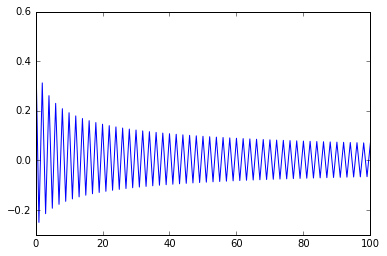

In [217]:
orb = iterate(F,100,.5)
plt.plot(orb)
plt.show()

### Create network

We will create a small world network by creating a ring of n nodes and connections between the non local nodes existing with probability p

In [218]:
def smallWorld(nNodes,p=0.1):
    """ Generates adjacency matrix for a small world
        class network
        
        Params:
        numNodes : number of nodes in network
        p : 
    
    """
    #Create a ring
    A = np.diag(np.ones(nNodes-1),1)
    A[0,-1] = 1
    A = A+A.T
    
    for i in range(nNodes):
        for j in range(nNodes):
            if i!=j:
                if np.random.rand() > (1-p):
                    A[i,j] = 1
                    A[j,i] = 1
    return A
            

In [258]:
A = smallWorld(10)
A

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 1., 0., 0., 1., 0., 1., 0.],
       [0., 0., 1., 0., 1., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 1., 0., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 1., 1.],
       [0., 0., 1., 1., 0., 0., 1., 1., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 1., 1., 0.]])

### Model ocilation in the nodes

Below, we initialize a small world network adjacency matrix, randomize the starting values of each node and iterate our synchronization model according to the following discrete time equation:

$x_i(k+1) = F(x_i(k)) + d∑ L_{ij} x_j(k)$

Where L is the Laplacian of adjecency matrix A, and d is a dampening coefficient

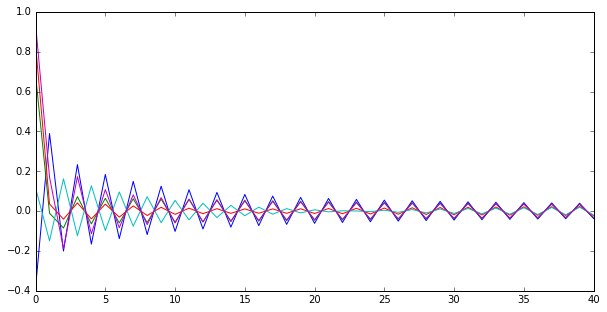

In [452]:
"""Parameters"""
#Number of nodes:
nNodes = 10
#Dampening parameter
d = .06
#Probability of small world link
p = .1
#Number of iterates
iters = 40

#Randomize node initial values and compute Laplacian
nodes = np.random.rand(nNodes)*2 -1
A = smallWorld(nNodes,p=p)
deg = A.sum(axis=0)
L = np.diag(deg) - A
def Synch(x):
    return F(x) + d*np.dot(L,x)#/np.mean(deg)

#Simulate Model
orb = np.array(iterate(Synch,iters,nodes))

#Plot five orbits
if nNodes >= 5:
    #Randomly choose orbits
    r0,r1,r2,r3,r4 = np.random.choice(range(nNodes),size=5,replace=False)
    plt.rcParams['figure.figsize'] = (10,5)
    plt.plot(orb[:,r0])
    plt.plot(orb[:,r1])
    plt.plot(orb[:,r2])
    plt.plot(orb[:,r3])
    plt.plot(orb[:,r4])
    #plt.savefig('orbit_d.4n10p.1.png',dpi=150)
    plt.show()
    
else:
    #Plot the first two orbits
    plt.plot(orb[:,0])
    plt.plot(orb[:,1])
    plt.show()


The plot above shows some promising behavior! Ocilations converging towards stability. After trying different parameter combinations, I found that the following trend was consistent for almost all p values and graph sizes.

### Plots

** Control ** 10 Nodes, $d = 0$ i.e. no network effect

<img src=orbit_d0.png>

As expected, we see ocilation without synchronization. 


** Synchronization **
10 Nodes, $d = 0.1$, $p = 0.1$ 
<img src=orbit_d.1n10p.1.png>
The obits begin in very different positions and slowly converge to the same orbit. Around the iteration twenty, we see synchronization.

**Less damping**
10 Nodes, $d=0.2$, $p=0.1$
<img src=orbit_d.2n10p.1.png>
As we might expect, expected, with less midigation of network effects, synchronization occurs earlier.

**Divergence** 10 Nodes, $d=0.4$, $p=0.1$
<img src=orbit_d.4n10p.1.png>
Unfortunately, when d becomes too large, the system diverges. It is unclear why this is. No matter what graph size I tried, or what p value, the system diverged if d was bigger that about 0.7

### Analysis

We are looking for a system where,

$$\lim_{m\to\infty} F^{m}(x) + (\frac{1}{d}L)^mx = F^{m}(x)\quad x = (x_1,x_2,...x_n)^T$$

This simpifies to

$$\lim_{m\to\infty} (\frac{1}{d}L)^mx = 0 $$


$$(\frac{1}{d}L)^mx = (\frac{1}{d}L)^m(\alpha_0v_0 + \cdots + \alpha_nv_n)$$


Where $v_0,...,v_n$ are the eigenvectors of L with associated weights $\alpha_0,...\alpha_n$. The expression above simplifies to:


$$(\frac{\lambda_0}{d})^m\alpha_0v_0 + (\frac{\lambda_1}{d})^m\alpha_1v_1 + \cdots + (\frac{\lambda_n}{d})^m\alpha_nv_n)$$

Where $\lambda_0, ..., \lambda_n$ are the eigenvalues of $L$ from smallest to largest.

If d is large enough, $d > \lambda_n$, then $d$ can force convergence.

$$\lim_{m\to\infty} (\frac{\lambda_0}{d})^m\alpha_0v_0 + (\frac{\lambda_1}{d})^m\alpha_1v_1 + \cdots + (\frac{\lambda_n}{d})^m\alpha_nv_n) = 0$$
If $\frac{\lambda_i}{d} < 1$ for all $i$.

It is important to note that numeric tests demonstrated that this condition is sufficient, but not necessary.

### Comments

Maybe this isn't the model we want, since it is possible to force convergence by adjusting $d$. I'm not sure how to define synchronization when it is dependent on d.